# Encoding/Predicting structured data

## Categorical and continuous data
When working with structured data, we can think of it as having two types of data:

1. Categorical data (data broken down into categories)
2. Continuous data (numbers, etc. -- things that can continue indefinitely)

Realize that any continuous data could also be used as categorical data (though obviously there are cases where this might be impractical -- if you would end up with thousands of categories, for example). Though not all categorical data could be used as continuous data (if we had two types of store in our data, that couldn't be continuous. We just have A and B).

One interesting case is dates. When it comes to dates, it's often better to handle them as categorical data rather than continuous data.

## Data types and neural nets
With continuous data, neural nets will try to come up with a smooth function to predict each data point.

With categorical data, neural nets can treat each category completely differently.

This is why it makes more sense to handle dates as categorical data.

There isn't necessarily a connection BETWEEN Sunday and Monday, say. Rather Sunday and Monday are completely different categories that may be interesting AS categories, rather than as connected data.

## Cardinality
When we talk about the __cardinality__ of connected data, we are talking about the number of categories. Our cardinality will normally be `number_of_categories + 1`, where 1 is for the unknown category.

For example, days of the week would have a cardinality of 8.

## Dependent variables
The dependent variable is the variables we are trying to predict. For example, sales numbers. In the fast.ai library, the dependent variable is removed from the data frame we are processing.

## Validation sets for time series data
Since we are trying to predict the future, when using time series data, we typically use a validation set that will be taken from the end of the time series. For example, if we are trying to predict the next 2 weeks of sales, we would typically take the last 2 weeks of sales from our training set as the validation set.

## Embeddings
Think of categorical data. We could one-hot encode it, like this:

In [3]:
import pandas as pd
import numpy as np

In [10]:
one_hot_matrix = np.array(
[[1, 0, 0, 0, 0, 0, 0],
[0, 1, 0, 0, 0, 0, 0],
[0, 0, 1, 0, 0, 0, 0],
[0, 0, 0, 1, 0, 0, 0],
[0, 0, 0, 0, 1, 0, 0],
[0, 0, 0, 0, 0, 1, 0],
[0, 0, 0, 0, 0, 0, 1]])

df = pd.DataFrame(one_hot_matrix, index=['Monday', 'Tuesday', 'Wednesday', 'Thursday', 'Friday', 'Saturday', 'Sunday'])

In [11]:
df

,0,1,2,3,4,5,6
Monday,1,0,0,0,0,0,0
Tuesday,0,1,0,0,0,0,0
Wednesday,0,0,1,0,0,0,0
Thursday,0,0,0,1,0,0,0
Friday,0,0,0,0,1,0,0
Saturday,0,0,0,0,0,1,0
Sunday,0,0,0,0,0,0,1


The problem with this approach is that every day of the week is equal to each other. A better approach is to use __encodings__. Encoding essentially means using a matrix of __n__ columns and __num_of_categories__ rows. Then, when you pick a category, you pick a row of numbers from this __embedding matrix__. These numbers start out random, but can be tweaked and learned by the neural network.

This way, by tweaking the numbers, we can get a rich representation of the days. For example, we might find that Saturday and Sunday have the same kind of relationship.

In [12]:
encoding_df = pd.DataFrame(np.random.randn(7, 4), index=['Monday', 'Tuesday', 'Wednesday', 'Thursday', 'Friday', 'Saturday', 'Sunday'])

In [13]:
encoding_df

,0,1,2,3
Monday,-0.225873,0.580005,-0.457248,-0.795360
Tuesday,1.070281,-1.200492,-0.525535,-1.182165
Wednesday,0.659523,-0.703516,-0.142187,1.995919
Thursday,0.289510,0.812477,-0.948973,0.707514
Friday,-1.408670,-0.264204,-0.076589,-0.666953
Saturday,0.036788,-0.048588,0.916669,0.512508
Sunday,-0.597314,-0.590090,-2.000963,0.667598


__Question:__ how do we know how many columns to add to the encoding matrix?

__Answer:__ Jeremy suggests `max(50, num_of_categories/2)`.

## Basic steps for creating a deep learning model for structured data

0. (Feature engineering/data wrangling)
1. Decide what you want your categorical and continuous data to be, put it in a data frame
2. Create validation set
3. Set data using `ColumnarModelData.from_data_frame`
4. Determine how big embedding matrices should be (see heuristic above)
5. Call `get_learner` for sample set
6. Call `fit` for sample set, tweak params as required
7. Repeat steps 5-6 for all of training data
8. Repeat steps 5-6 for test data
9. Create submission and submit (Kaggle)

## Root Mean Squared Error
The contest uses root mean squared error percentage as the evaluation metric.

This is basically just another way to measure how accurate a model is.

Imagine you have a line going through a series of data points, RMSE will tell you how well your line fits the data.

We take the square of each residual (how far a data point is away from your regression line), add up all of those squares, divide by the number of samples-1, and take the square root.

The lower the number, the better. For a correlation coefficient of 1, the RMSE would be 0.

Example: If we were studying study time/caffine intake, and our RMSE was 1.5, it would be like saying our estimates using this model are typically off by 1.5 hours. (See Khan Academy stats notes for more).

## How to run
(First we perform various data wrangling/feature engineering and save the data a file using feather. This is quite an involved process, not deep learning specific. See the lesson3-rossman notebook for exact details of these steps.)

In [1]:
# Import the libraries and set the path

%matplotlib inline
%reload_ext autoreload
%autoreload 2

from fastai.structured import *
from fastai.column_data import *
np.set_printoptions(threshold=50, edgeitems=20)

PATH='data/rossmann/'

In [2]:
# Load up the data from our previously created files
joined = pd.read_feather(f'{PATH}joined')
joined_test = pd.read_feather(f'{PATH}joined_test')

In [4]:
# This file contains one big data frame made up of data joined together from other data frames/files
# (Hence why the dataframe is called "joined")
joined.head()

,index,Store,DayOfWeek,Date,Sales,Customers,Open,Promo,StateHoliday,SchoolHoliday,...,AfterStateHoliday,BeforeStateHoliday,AfterPromo,BeforePromo,SchoolHoliday_bw,StateHoliday_bw,Promo_bw,SchoolHoliday_fw,StateHoliday_fw,Promo_fw
0,0,1,5,2015-07-31,5263,555,1,1,False,1,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1,1,2,5,2015-07-31,6064,625,1,1,False,1,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2,2,3,5,2015-07-31,8314,821,1,1,False,1,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
3,3,4,5,2015-07-31,13995,1498,1,1,False,1,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
4,4,5,5,2015-07-31,4822,559,1,1,False,1,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


In [7]:
# Now we need to create our categorical variables and continuous variables
categorical_variables = ['Store', 'DayOfWeek', 'Year', 'Month', 'Day', 'StateHoliday', 'CompetitionMonthsOpen',
    'Promo2Weeks', 'StoreType', 'Assortment', 'PromoInterval', 'CompetitionOpenSinceYear', 'Promo2SinceYear',
    'State', 'Week', 'Events', 'Promo_fw', 'Promo_bw', 'StateHoliday_fw', 'StateHoliday_bw',
    'SchoolHoliday_fw', 'SchoolHoliday_bw']

continuous_variables = ['CompetitionDistance', 'Max_TemperatureC', 'Mean_TemperatureC', 'Min_TemperatureC',
   'Max_Humidity', 'Mean_Humidity', 'Min_Humidity', 'Max_Wind_SpeedKm_h', 
   'Mean_Wind_SpeedKm_h', 'CloudCover', 'trend', 'trend_DE',
   'AfterStateHoliday', 'BeforeStateHoliday', 'Promo', 'SchoolHoliday']

In [8]:
dependent_variable = 'Sales'
joined = joined[categorical_variables+continuous_variables+[dependent_variable, 'Date']].copy()

In [10]:
joined_test[dependent_variable] = 0
joined_test = joined_test[categorical_variables+continuous_variables+[dependent_variable, 'Date', 'Id']].copy()

In [11]:
# Transform specific columns in the dataframe to category types
for variable in categorical_variables: joined[variable] = joined[variable].astype('category').cat.as_ordered()

In [12]:
# Transform any string columns in categorical variables using joined as a template
apply_cats(joined_test, joined)

In [14]:
# Now we will transform the continuous variable columns.
# These are transformed to float32 because this is the type expected by PyTorch
for variable in continuous_variables:
    joined[variable] = joined[variable].astype('float32')
    joined_test[variable] = joined_test[variable].astype('float32')

In [32]:
# We're going to create some sample data to run on
joined_size = len(joined)

indices = get_cv_idxs(joined_size, val_pct=150000/joined_size)
joined_sample = joined.iloc[indices].set_index('Date')

sample_size = len(joined_sample)
sample_size

150000

In [23]:
# We need to do a quick data fix
joined_sample['AfterStateHoliday']=joined_sample['AfterStateHoliday'].fillna(0)
joined_sample['BeforeStateHoliday']=joined_sample['BeforeStateHoliday'].fillna(0)

In [30]:
# Now we set up our data by processing our dataframe
# joined_sample is passed in, and we get df (dataframe) out
# But this dataframe has the dependent variable -- Sales -- removed
# Neural nets like input data to be aruond 0 with standard deviation of 1. do_scale=True sets this up
# nas sets na values to 0s or a median value for continuous data
# mapper stores the results from do_scale so the same scaling can be applied to the test set
df, dependent_variable, nas, mapper = proc_df(joined_sample, 'Sales', do_scale=True)

# This is to make the evaluation metric easier
dependent_variable_log = np.log(dependent_variable)

In [36]:
# Set up our test data in the same way
joined_test = joined_test.set_index("Date")
df_test, _, nas, mapper = proc_df(joined_test, 'Sales', do_scale=True, skip_flds=['Id'],
                                  mapper=mapper, na_dict=nas)

In [33]:
# Take the last 25% of rows sorted by date as the cross-validation data
# (In time-series, we don't want to just take random rows, as discussed above)
training_ratio = 0.75
training_size = int(sample_size * training_ratio)
validation_indexes = list(range(training_size, len(df)))

In [34]:
# Define the root mean squared percent error function
def inv_y(a): return np.exp(a)

def exp_rmspe(y_pred, targ):
    targ = inv_y(targ)
    pct_var = (targ - inv_y(y_pred))/targ
    return math.sqrt((pct_var**2).mean())

max_log_y = np.max(yl)
y_range = (0, max_log_y*1.2)

In [37]:
# Now we set up our model data.
model_data = ColumnarModelData.from_data_frame(PATH, validation_indexes, df, dependent_variable_log.astype('float32'), cat_flds=categorical_variables, 
                                              bs=128, test_df=df_test)

In [38]:
# Now we set up the size of our encoding matrices
# First, we want to get the size of each of categories, and add +1 to account for the 'Unknown' category
category_sizes = [(category, len(joined_sample[category].cat.categories)+1) for category in categorical_variables]

In [39]:
category_sizes

[('Store', 1116),
 ('DayOfWeek', 8),
 ('Year', 4),
 ('Month', 13),
 ('Day', 32),
 ('StateHoliday', 3),
 ('CompetitionMonthsOpen', 26),
 ('Promo2Weeks', 27),
 ('StoreType', 5),
 ('Assortment', 4),
 ('PromoInterval', 4),
 ('CompetitionOpenSinceYear', 24),
 ('Promo2SinceYear', 9),
 ('State', 13),
 ('Week', 53),
 ('Events', 22),
 ('Promo_fw', 1),
 ('Promo_bw', 1),
 ('StateHoliday_fw', 1),
 ('StateHoliday_bw', 1),
 ('SchoolHoliday_fw', 1),
 ('SchoolHoliday_bw', 1)]

In [41]:
# Then we use the number of categories/2, with a cap of 50 to set the encoding matrix size
# (This is a heuristic)
embedding_sizes = [(category, min(50, (category+1)//2)) for _, category in category_sizes]

In [42]:
embedding_sizes

[(1116, 50),
 (8, 4),
 (4, 2),
 (13, 7),
 (32, 16),
 (3, 2),
 (26, 13),
 (27, 14),
 (5, 3),
 (4, 2),
 (4, 2),
 (24, 12),
 (9, 5),
 (13, 7),
 (53, 27),
 (22, 11),
 (1, 1),
 (1, 1),
 (1, 1),
 (1, 1),
 (1, 1),
 (1, 1)]

In [43]:
# Now we'll find the learning rate
# len(df.columns)-len(categorical_variables) = get the number of continuous variables
# 0.04 = dropout
# [1000, 500] = number of activations in each layer
# [0.001, 0.01] = dropout in later layers

m = model_data.get_learner(embedding_sizes, len(df.columns)-len(categorical_variables),
                   0.04, 1, [1000,500], [0.001,0.01], y_range=y_range)
lr = 1e-3

In [44]:
m.lr_find()

HBox(children=(IntProgress(value=0, description='Epoch', max=1), HTML(value='')))

 62%|██████▏   | 547/879 [00:07<00:04, 69.14it/s, loss=0.636]


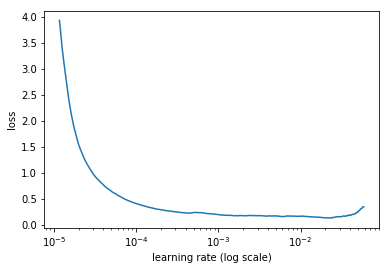

In [45]:
m.sched.plot()

In [46]:
# Now we'll do our learning like usual
# Note we can pass in whatever metric we want. This will just be printed out after each epoch.
m.fit(lr, 3, metrics=[exp_rmspe])

HBox(children=(IntProgress(value=0, description='Epoch', max=3), HTML(value='')))

epoch      trn_loss   val_loss   exp_rmspe                     
    0      0.030914   0.029612   0.174102  
    1      0.022637   0.01976    0.152743                      
    2      0.018524   0.018284   0.14046                       



[0.018283583, 0.1404602349570145]

In [47]:
m.fit(lr, 5, metrics=[exp_rmspe], cycle_len=1)

HBox(children=(IntProgress(value=0, description='Epoch', max=5), HTML(value='')))

epoch      trn_loss   val_loss   exp_rmspe                     
    0      0.013564   0.014091   0.122443  
    1      0.012933   0.01352    0.119295                      
    2      0.012006   0.012626   0.115652                      
    3      0.011302   0.012518   0.114587                      
    4      0.010589   0.012158   0.113845                      



[0.012157828, 0.11384540231735718]

In [48]:
m.fit(lr, 2, metrics=[exp_rmspe], cycle_len=4)

HBox(children=(IntProgress(value=0, description='Epoch', max=8), HTML(value='')))

epoch      trn_loss   val_loss   exp_rmspe                     
    0      0.014235   0.013558   0.124943  
    1      0.011222   0.013527   0.118383                      
    2      0.009054   0.011497   0.110866                       
    3      0.007939   0.011174   0.109424                       
    4      0.012106   0.012363   0.122124                      
    5      0.00942    0.012937   0.115548                       
    6      0.008067   0.010562   0.108079                      
    7      0.007329   0.010672   0.107174                       



[0.010672021, 0.10717355006380637]

At this point, out model looks like it's working, so we'd train it on the full training set, and then run the test set.

Then we'd create our file for submission.